In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from skimage.data import imread

import os


# Any results you write to the current directory are saved as output.

In [32]:
#!pip install scikit-image

In [12]:
COMPETITION_NAME= 'airbus-ship-detection'
PATH = os.path.expanduser(f"~/.kaggle/competitions/{COMPETITION_NAME}")


In [14]:
!ls {PATH}

sample_submission.csv	   train
sample_submission.csv.zip  train_ship_segmentations.csv
test			   train_ship_segmentations.csv.zip
test.zip		   train.zip


In [15]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [16]:
masks = pd.read_csv(os.path.join(PATH+"/train_ship_segmentations.csv"))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

131030 masks found
104070


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


In [19]:
from sklearn.model_selection import train_test_split
unique_img_ids = masks.groupby('ImageId').size().reset_index(name='counts')
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.3, 
                 stratify = unique_img_ids['counts'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')


91709 training masks
39321 validation masks


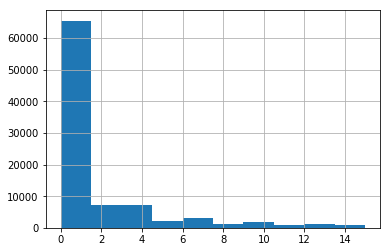

In [20]:
train_df['counts'] = train_df.apply(lambda c_row: c_row['counts'] if 
                                    isinstance(c_row['EncodedPixels'], str) else
                                    0, 1)
train_df['counts'].hist()

In [21]:
def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [24]:
train_df.head()

,ImageId,EncodedPixels,counts
0,00003e153.jpg,NaN,0
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...,9
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...,9
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...,9


In [26]:
train_df[train_df['ImageId']=='00021ddc3.jpg'] 

,ImageId,EncodedPixels,counts
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...,9
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...,9
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...,9
5,00021ddc3.jpg,150423 2 151190 3 151958 3 152726 4 153495 3 1...,9
6,00021ddc3.jpg,139644 2 140408 6 141174 9 141942 9 142711 6 1...,9
7,00021ddc3.jpg,86727 2 87493 4 88261 4 89030 3 89798 4 90566 ...,9
8,00021ddc3.jpg,74441 3 75207 5 75975 5 76743 5 77511 5 78280 ...,9
9,00021ddc3.jpg,75972 3 76738 5 77506 5 78274 5 79042 6 79811 ...,9
10,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,9


In [38]:
def display_image(image_id, masks_df):
    img = imread(f'{PATH}/train/{image_id}')
    img_masks = masks.loc[masks['ImageId'] == image_id, 'EncodedPixels'].tolist()

    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768))
    for mask in img_masks:
        all_masks += rle_decode(mask)

    fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[2].axis('off')
    axarr[0].imshow(img)
    axarr[1].imshow(all_masks)
    axarr[2].imshow(img)
    axarr[2].imshow(all_masks, alpha=0.4)
    plt.tight_layout(h_pad=0.1, w_pad=0.1)
    plt.show()

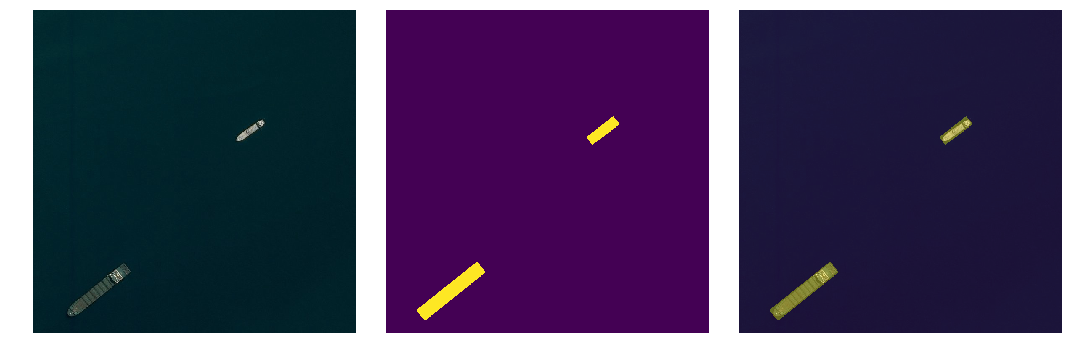

In [41]:
ImageId = '0005d01c8.jpg'
display_image(image_id=ImageId, masks_df =train_df )

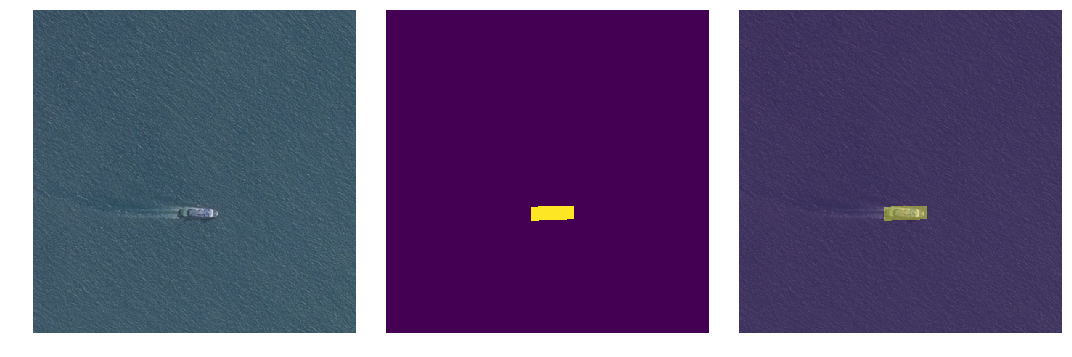

In [42]:
ImageId = '000155de5.jpg'
display_image(image_id=ImageId, masks_df =train_df )

In [44]:
%%bash
# From tensorflow/models/research/
wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
tar -xvf images.tar.gz
tar -xvf annotations.tar.gz

images/
images/boxer_16.jpg
images/chihuahua_165.jpg
images/pug_183.jpg
images/english_setter_1.jpg
images/chihuahua_170.jpg
images/english_cocker_spaniel_17.jpg
images/samoyed_39.jpg
images/Egyptian_Mau_62.jpg
images/samoyed_36.jpg
images/german_shorthaired_3.jpg
images/Ragdoll_183.jpg
images/British_Shorthair_64.jpg
images/american_pit_bull_terrier_57.jpg
images/beagle_120.jpg
images/american_bulldog_174.jpg
images/chihuahua_101.jpg
images/shiba_inu_136.jpg
images/Abyssinian_136.jpg
images/Siamese_201.jpg
images/Abyssinian_85.jpg
images/saint_bernard_145.jpg
images/Siamese_63.jpg
images/leonberger_164.jpg
images/Maine_Coon_126.jpg
images/samoyed_51.jpg
images/Birman_15.jpg
images/english_cocker_spaniel_181.jpg
images/english_cocker_spaniel_128.jpg
images/leonberger_133.jpg
images/english_cocker_spaniel_6.jpg
images/miniature_pinscher_119.jpg
images/american_pit_bull_terrier_27.jpg
images/Abyssinian_37.jpg
images/Bombay_91.jpg
images/Egyptian_Mau_6.jpg
images/Maine_Coon_173.jpg
images

--2018-08-01 03:47:54--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  273K 47m11s
    50K .......... .......... .......... .......... ..........  0%  550K 35m18s
   100K .......... .......... .......... .......... ..........  0% 8.82M 24m0s
   150K .......... .......... .......... .......... ..........  0% 7.47M 18m26s
   200K .......... .......... .......... .......... ..........  0%  594K 19m5s
   250K .......... .......... .......... .......... ..........  0% 6.93M 16m12s
   300K .......... .......... .......... .......... ..........  0% 10.4M 14m4s
   350K .......... .......... .......... .......... ..........  0% 9.88M 12m28s
   